# Bayesian Hidden Markov Models 

In [2]:
using Turing, StatsPlots, Random

In [3]:
Random.seed!(12345678);

In [4]:
# Simple sstate detection
# Define the emission parameter.
y = [ 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0];
N = length(y);  K = 3;

# Plot the data we just made.
StatsPlots.plot(y, 
    xlim = (0,30), 
    ylim = (-1,5),
    size = (500, 250))

In [5]:
# Turing model definition
@model BayesHMM(y, K)= begin
    # Get obs lenght
    N= length(y)
    
    # State sequence
    s= tzeros(Int, N)
    
    # Emission matrix
    m= Vector(undef, K)
    
    # Transition matrix
    T= Vector{Vector}(undef, K)
    
    # Assing distribution to each element of the transition matrix
    # and the emission matrix
    for i= 1:K
        T[i]~ Turing.Dirichlet(ones(K)/K)
        m[i]~ Turing.Normal(i, 0.5)
    end
    
    # Observe each point of the input
    s[1]~ Turing.Categorical(K)
    y[1]~ Turing.Normal(m[s[1]], 0.1)
    
    for i= 2:N
        s[i]~ Turing.Categorical(vec(T[s[i-1]]))
        y[i]~ Turing.Normal(m[s[i]], 0.1)
    end
    
end

BayesHMM (generic function with 2 methods)

In [6]:
g= Turing.Gibbs(Turing.HMC(0.01, 50, :m, :T), Turing.PG(100, :s))
chain= Turing.sample(BayesHMM(y, 3), g, 500)

Sampling: 100%|█████████████████████████████████████████| Time: 0:11:07


Chains MCMC chain (500×43×1 Array{Float64, 3}):

Iterations        = 1:1:500
Number of chains  = 1
Samples per chain = 500
Wall duration     = 709.09 seconds
Compute duration  = 709.09 seconds
parameters        = T[1][1], T[1][2], T[1][3], T[2][1], T[2][2], T[2][3], T[3][1], T[3][2], T[3][3], m[1], m[2], m[3], s[1], s[2], s[3], s[4], s[5], s[6], s[7], s[8], s[9], s[10], s[11], s[12], s[13], s[14], s[15], s[16], s[17], s[18], s[19], s[20], s[21], s[22], s[23], s[24], s[25], s[26], s[27], s[28], s[29], s[30]
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

     T[1][1]    0.8702    0.1054     0.0047    0.0147     42.8731    0.9988    ⋯
     T[1][2]    0.1002    0.0832     0.0037    0.0129     28.0631    0.9983    ⋯
     T[1][3]    0.0296    0.0731     0.0033    0.0109     30.5473    0.9985    ⋯
     T[2][1]    0.1177    0.0869     0.

┌ Info: Saved animation to 
│   fn = /home/doppelganger/intro-to-julia/tmp.gif
└ @ Plots /home/doppelganger/.julia/packages/Plots/hxZ0l/src/animation.jl:114


Plots.AnimatedGif("/home/doppelganger/intro-to-julia/tmp.gif")
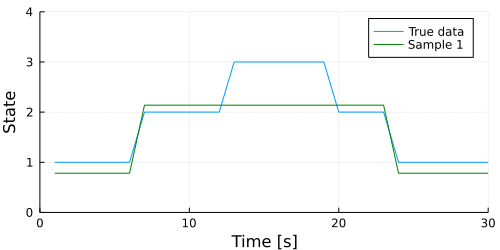

In [13]:
# Exctract the m and s parameters from the chain
m_set= MCMCChains.group(chain, :m).value
s_set= MCMCChains.group(chain, :s).value

# Iterate through the MCMC sample
Ns= 1:length(chain)

# Make the animation
animation= @gif for i in Ns
    m= m_set[i, :];
    s= Int.(s_set[i, :]);
    emissios= m[s]
    
    p= StatsPlots.plot(y, chain= :red,
        size=(500, 250),
        xlabel= "Time [s]",
        ylabel= "State",
        legend= :topright, label= "True data",
        xlim= (0,30),
        ylim=(0,4)
        )
    plot!(emissios, color= :green,
        label= "Sample $i")
end every 3    

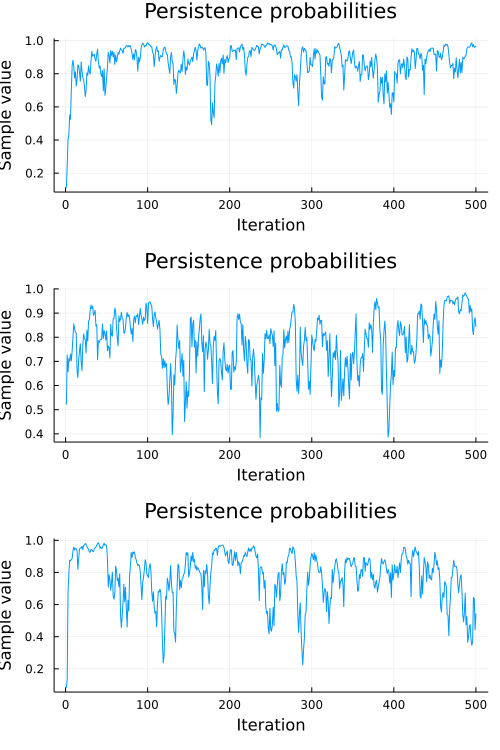

In [15]:
# Index the chain with the persitance matrix
subchain= chain[["T[1][1]", "T[2][2]", "T[3][3]"]]

plot(subchain, 
    seriestype= :traceplot,
    title= "Persistence probabilities",
    legen= false)


In [34]:
Turing.heideldiag(MCMCChains.group(chain, :T))[1]

Heidelberger and Welch diagnostic - Chain 1
  parameters     burnin   stationarity    pvalue      mean   halfwidth     tes ⋯
      Symbol      Int64           Bool   Float64   Float64     Float64     Boo ⋯

     T[1][1]     0.0000         1.0000    0.7910    0.8529      0.0254   1.000 ⋯
     T[1][2]     0.0000         1.0000    0.9849    0.1275      0.0206   0.000 ⋯
     T[1][3]     0.0000         1.0000    0.1568    0.0195      0.0100   0.000 ⋯
     T[2][1]     0.0000         1.0000    0.6013    0.0980      0.0178   0.000 ⋯
     T[2][2]     0.0000         1.0000    0.9139    0.7306      0.0261   1.000 ⋯
     T[2][3]     0.0000         1.0000    0.7931    0.1715      0.0232   0.000 ⋯
     T[3][1]   400.0000         1.0000    0.1068    0.0575      0.0407   0.000 ⋯
     T[3][2]     0.0000         1.0000    0.4446    0.1808      0.0362   0.000 ⋯
     T[3][3]   100.0000         1.0000    0.4289    0.7546      0.0395   1.000 ⋯
                                                                